# Aiyagari (1994) in Continuous Time with Julia

## By [Shunsuke Hori](https://github.com/Shunsuke-Hori)

In [1]:
using QuantEcon
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
mutable struct Household{TF<:AbstractFloat, TI<:Integer, TAV <: AbstractVector}
    dep::TF
    TFP::TF
    alpha::TF
    r::TF
    w::TF
    rho::TF
    a_max::TF
    a_min::TF
    a_size::TI
    a_vals::TAV
    da::TF
    pi::Array{TF,2}
    z_vals::Vector{TF}
    z_size::TI
    z_ave::TF
    z_transition::SparseMatrixCSC{TF,TI}
    n::TI
    delta::TF
    v::Array{TF,2}
    g::Matrix{TF}
    ssf::Array{TF,2}
    ssb::Array{TF,2}
    A::SparseMatrixCSC{TF,TI}
    B::SparseMatrixCSC{TF,TI}
    b::Vector{TF}
end

In [3]:
function Household(;
                 dep::AbstractFloat=0.05,   ###ADDED DEPRECIATION
                 TFP::Real=0.1,
                 alpha::AbstractFloat=0.33,
                 r::AbstractFloat=0.03,      # interest rate
                 w::AbstractFloat=1.0,       # wages
                 rho::AbstractFloat=0.04,    # discount factor
                 a_max::AbstractFloat=40.0,
                 a_min::AbstractFloat=1e-10, # minimum asset amount
                 a_size::Integer=1000,    # number of asset grid points
                 pi::AbstractArray=[-0.33 0.33; 0.33 -0.33], # poisson Jumps
                 z_vals::AbstractVector=[1.0, 2.0], # exogenous income states
                 delta::AbstractFloat=1000.0)
    # Initialize values, and set up grids over a and z
    r, w, rho, dep = r, w, rho, dep
    da = (a_max-a_min)/(a_size-1)
    z_size = length(z_vals)
    a_vals = linspace(a_min, a_max, a_size)
    n = a_size * z_size
    ###### ADDED TO MATCH LABOR SUPPLY IN .m
    z_ave = (z_vals[1]*pi[1, 2] + z_vals[2]*pi[2, 1]) /
                       (pi[1, 2] + pi[2, 1])

    # Initial Guess of Value Function (z_size x a_size matrix)
    v = log.(repmat(a_vals', z_size, 1)*r + w*repmat(z_vals, 1, a_size))/rho

    # Build skill_transition, the matrix summarizing transitions due to the Poisson income shocks
    # This is analogous to the Q matrix in the discrete time version of the QuantEcon Aiyagari model
    z_transition = kron(pi, speye(a_size))

    # Preallocation
    g = similar(v)
    ssf = zeros(v)
    ssb = zeros(v)
    A = similar(z_transition)
    B = copy(z_transition)
    b = Vector{Float64}(n)
    return Household(
    dep, TFP, alpha, r, w,
    rho, a_max,
    a_min,
    a_size,
    a_vals,
    da,
    pi,
    z_vals,
    z_size,
    z_ave,
    z_transition,
    n,
    delta,
    v, g,
    ssf, ssb, A, B, b)
end


Household

In [4]:
"""
Resets prices
Calling the method will resolves the Bellman Equation.
Parameters:
-----------------
- `r` : Interest rate
- `w` : wage
"""
function  set_prices!(hh::Household, r::AbstractFloat, w::AbstractFloat;
                       maxiter::Integer=100, crit::AbstractFloat = 1e-6)
    hh.r, hh.w = r, w
    solve_bellman!(hh, maxiter = maxiter, crit = crit)
    return nothing
end

"""
Reinitializes the value function if the value function
became NaN
"""
function reinitialize_v!(hh::Household)
    hh.v = log.(repmat(hh.a_vals', hh.z_size, 1)*hh.r +
             hh.w * repmat(hh.z_vals, 1, hh.a_size))/hh.rho
    return nothing
end

reinitialize_v!

In [5]:
"""
This function solves the decision problem with the given parameters
Parameters:
-----------------
- `maxiter` : maximum number of iteration before haulting value function iteration
- `crit` : convergence metric, stops if value function does not change more than crit
"""
function solve_bellman!(hh::Household;
                   maxiter::Integer=100, crit::AbstractFloat=1e-6)
    A, B, v, ssf, ssb, b = hh.A, hh.B, hh.v, hh.ssf, hh.ssb, hh.b
    a_vals, a_size, z_vals, z_size, r, w, da, n, delta, rho =
        hh.a_vals, hh.a_size, hh.z_vals, hh.z_size, hh.r, hh.w,
        hh.da, hh.n, hh.delta, hh.rho

    dist = 100.0

    for i in 1:maxiter
        println("i = $i")
        # compute saving and consumption implied by current guess for value function, using upwind method
        dv = (v[:, 2:end] .- v[:, 1:end-1])/da
        cf = 1.0./dv
        c0 = repmat(a_vals', z_size, 1)*r .+ w*repmat(z_vals, 1, a_size)
        # computes savings with forward forward difference and backward difference
        ssf[:, 1:end-1] .= c0[:, 1:end-1] .- cf
        ssb[:, 2:end] .= c0[:, 2:end] .- cf
        # Note that the boundary conditions are handled implicitly as ssf will be zero at a_max and ssb at a_min
        is_forward = ssf .> 0
        is_backward = ssb .< 0
        # Update consumption based on forward or backward difference based on direction of drift
        c0[:, 1:end-1] .+= (cf .- c0[:, 1:end-1]) .* is_forward[:, 1:end-1]
        c0[:, 2:end] .+= (cf .- c0[:, 2:end]) .* is_backward[:, 2:end]
        u0 = log.(c0)
        # Build the matrix A that summarizes the evolution of the process for (a,z)
        # This is a Poisson transition matrix (aka intensity matrix) with rows adding up to zero
        A .= hh.z_transition
        diag_helper = vec((-ssf .* is_forward .+ ssb .* is_backward)')/da
        A += spdiagm(diag_helper, 0, n, n)
        diag_helper = vec((-ssb .* is_backward)')/da
        A += spdiagm(diag_helper[2:end], -1, n, n)
        diag_helper = vec((ssf .* is_forward)')/da
        A += spdiagm(diag_helper[1:end-1], 1, n, n)
        # Solve the system of linear equations corresponding to implicit finite difference scheme
        B .= speye(n) * (1/delta + rho) .- A
        b .= vec(u0') .+ vec(v')/delta
        v_old = copy(v)
        v .= reshape(\(B, b), a_size, z_size)'
        # Compute convergence metric and stop if it satisfies the convergence criterion
        dist = maximum(abs, v_old .- v)
        println("dist = $dist")
        if dist < crit
            hh.A .= A
            break
        end
    end
end

solve_bellman!

In [6]:
"""
Solves for the stationary distribution given household decision rules
Output:
Capital level from the stationary distribution
"""
function compute_stationary_distribution!(hh::Household)
    g = hh.g
    n, z_size, a_size, a_vals = hh.n, hh.z_size, hh.a_size, hh.a_vals

    AT = copy(hh.A')
    # The discretized Kolmogorov Forward equation AT*g=0 is an eigenvalue problem
    # AT is singular because one of the equation is the distribution adding
    # up to 1. Here we solve the eigenvalue problem by setting g(1,1)=0.1
    # and the equation is solved relative to that value.
    # Alternatively, one could use a routine for solving eigenvalue problems.
    b = zeros(n)
    b[1] = 0.1
    AT[1, :] = 0.0   # set first row all zero
    AT[1, 1] = 1.0   # set (1,1) element to be 1.0
    dropzeros!(AT)
    g .= reshape(\(AT, b), a_size, z_size)'
    # Since g was solved taking one of g(1,1) as given, g needs to be
    # renormalized to add up to 1
    g .= g/sum(g)
    return sum(g .* a_vals')
end


compute_stationary_distribution!

In [7]:
lam = 0.11
PI = [-lam lam; lam -lam]
am = Household(rho=0.05, r=0.02, w=1.0, pi=PI)

Household{Float64,Int64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}(0.05, 0.1, 0.33, 0.02, 1.0, 0.05, 40.0, 1.0e-10, 1000, 1.0e-10:0.04004004003993994:40.0, 0.04004004003993994, [-0.11 0.11; 0.11 -0.11], [1.0, 2.0], 2, 1.5, 
  [1   ,    1]  =  -0.11
  [1001,    1]  =  0.11
  [2   ,    2]  =  -0.11
  [1002,    2]  =  0.11
  [3   ,    3]  =  -0.11
  [1003,    3]  =  0.11
  [4   ,    4]  =  -0.11
  [1004,    4]  =  0.11
  [5   ,    5]  =  -0.11
  [1005,    5]  =  0.11
  ⋮
  [1995, 1995]  =  -0.11
  [996 , 1996]  =  0.11
  [1996, 1996]  =  -0.11
  [997 , 1997]  =  0.11
  [1997, 1997]  =  -0.11
  [998 , 1998]  =  0.11
  [1998, 1998]  =  -0.11
  [999 , 1999]  =  0.11
  [1999, 1999]  =  -0.11
  [1000, 2000]  =  0.11
  [2000, 2000]  =  -0.11, 2000, 1000.0, [3.99991e-11 0.0160096 … 11.7468 11.7557; 13.8629 13.871 … 20.5867 20.5924], [2.22428e-320 0.0 … 1.15152e-315 1.15152e-315; 1.97626e-323 2.31964e-320 … 0.0 6.95229e-310], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0

In [8]:
solve_bellman!(am)

i = 1
dist = 7.103006777890267
i = 2
dist = 1.4307639380779484
i = 3
dist = 0.35979365967417287
i = 4
dist = 0.15224764849882355
i = 5
dist = 0.07945166667344417
i = 6
dist = 0.0812135305006958
i = 7
dist = 0.08865369860560257
i = 8
dist = 0.09407830082802882
i = 9
dist = 0.03212325665573701
i = 10
dist = 0.0188089268062841
i = 11
dist = 0.012767723153269905
i = 12
dist = 0.007439765965876255
i = 13
dist = 0.003367241542981958
i = 14
dist = 0.0008499861506257034
i = 15
dist = 5.9713168446329234e-5
i = 16
dist = 8.390977930261556e-7


In [9]:
compute_stationary_distribution!(am)

0.6927464134085219

In [10]:
am.r = 0.02
am.w = 0.9

0.9

In [11]:
solve_bellman!(am)

i = 1
dist = 2.1353272979475566
i = 2
dist = 0.027446300398164425
i = 3
dist = 0.001194626263002263
i = 4
dist = 3.758397711628447e-5
i = 5
dist = 6.100745340020808e-7


In [12]:
compute_stationary_distribution!(am)

0.6232372053476747

In [13]:
set_prices!(am, 0.03, 0.9)

i = 1
dist = 1.1193557800694194
i = 2
dist = 0.07187401303638907
i = 3
dist = 0.0011349287670903152
i = 4
dist = 1.6790426538904057e-5
i = 5
dist = 2.582649720750396e-7


In [14]:
compute_stationary_distribution!(am)

1.1298333088364119

In [15]:
r_to_w(hh::Household, r::Real) =
    hh.TFP*(1 - hh.alpha)*(hh.alpha*hh.TFP / (hh.dep + r))^(hh.alpha / (1 - hh.alpha))
rd(hh::Household, K::Real) =
    hh.TFP*hh.alpha*(hh.z_ave / K)^(1 - hh.alpha) - hh.dep

rd (generic function with 1 method)

In [16]:
"""
Map prices to the induced level of capital stock.
Parameters:
----------
- `hh` : `Household`
         An instance of the Household type
- `r` : `Real`
        The interest rate
"""
function prices_to_capital_stock!(hh::Household, r::Real;
                                   maxiter::Integer=100,
                                   crit::AbstractFloat=1e-6)
    w = r_to_w(hh, r)

    # Set new prices and solve the Bellman equation
    set_prices!(hh, r, w, maxiter = maxiter, crit = crit)

    # Compute the stationary distribution and capital
    return compute_stationary_distribution!(hh)
end

prices_to_capital_stock!

In [17]:
# Compute supply of capital
r_vals = linspace(0.02, 0.048, 20)
k_vals = prices_to_capital_stock!.(am, r_vals)

i = 1
dist = 58.412624665207524
i = 2
dist = 14.364561351479773
i = 3
dist = 4.584470437320341
i = 4
dist = 1.2410047745011852
i = 5
dist = 0.3380062532356689
i = 6
dist = 0.12115648642142673
i = 7
dist = 0.05757198437972022
i = 8
dist = 0.011853550926439027
i = 9
dist = 0.0006181473565547435
i = 10
dist = 1.0593918723600382e-5
i = 11
dist = 1.9019021380017875e-7
i = 1
dist = 0.48116499190575235
i = 2
dist = 0.008514221244595443
i = 3
dist = 0.0001395708118594463
i = 4
dist = 2.105860890555533e-6
i = 5
dist = 2.8221386561000372e-8
i = 1
dist = 0.48884916856712257
i = 2
dist = 0.008754800682958752
i = 3
dist = 0.00014681841223307401
i = 4
dist = 2.294172869454769e-6
i = 5
dist = 3.2504454239301594e-8
i = 1
dist = 0.49612012791591376
i = 2
dist = 0.008985330561340987
i = 3
dist = 0.00015398287074575023
i = 4
dist = 2.4916307204136956e-6
i = 5
dist = 3.743358156782506e-8
i = 1
dist = 0.502953557028496
i = 2
dist = 0.009202928950964306
i = 3
dist = 0.00016074013403244436
i = 4
dist = 2.674

20-element Array{Float64,1}:
 0.0272353
 0.0287409
 0.0329915
 0.0366467
 0.0396432
 0.0441632
 0.0488313
 0.0541102
 0.0600183
 0.0672299
 0.0754847
 0.0853036
 0.0972495
 0.112065 
 0.131019 
 0.156268 
 0.191844 
 0.246303 
 0.341641 
 0.557325 


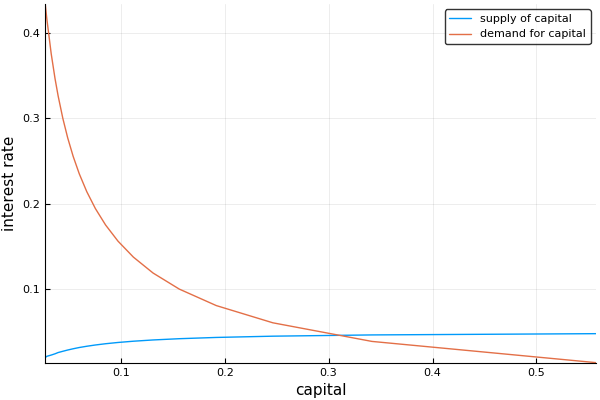

In [18]:
# Plot supply and demand of capital
p = plot(size = (600, 400), grid = true)
plot!(p, k_vals, r_vals, lab = "supply of capital")
plot!(p, k_vals, rd.(am, k_vals), lab = "demand for capital")
plot!(p, lw = 2, alpha = 2, leg = :topright)
plot!(p, xlabel = "capital", ylabel = "interest rate")

In [19]:
function r_error(am::Household, r::Real;
                  maxiter::Integer=100, crit::AbstractFloat=1e-6)
    set_prices!(am, r, r_to_w(am, r), maxiter = maxiter, crit = crit)
    r_new = rd(am, compute_stationary_distribution!(am))
    return r_new - r
end

r_error (generic function with 1 method)

In [20]:
r_min = 0.02
r_max = 0.05
bisect(r -> r_error(am, r), r_min, r_max)

i = 1
dist = 10.12773511885143
i = 2
dist = 1.1367214213794767
i = 3
dist = 0.0954121327508517
i = 4
dist = 0.012664252449361868
i = 5
dist = 0.00031442703381401316
i = 6
dist = 5.038447987715244e-6
i = 7
dist = 9.582290516618741e-8
i = 1
dist = 10.75944321295667
i = 2
dist = 1.4761243332702492
i = 3
dist = 0.12327812389541748
i = 4
dist = 0.002540473185561609
i = 5
dist = 4.65770248752051e-5
i = 6
dist = 8.728252680612059e-7
i = 1
dist = 5.596973354753294
i = 2
dist = 0.4282724093010728
i = 3
dist = 0.015393180166221043
i = 4
dist = 0.00031279402674755374
i = 5
dist = 5.674373383612874e-6
i = 6
dist = 1.0991569610041552e-7
i = 1
dist = 2.767493808054992
i = 2
dist = 0.10582621712654117
i = 3
dist = 0.0020404233099213798
i = 4
dist = 3.95258444214619e-5
i = 5
dist = 7.670457762287697e-7
i = 1
dist = 1.4059346970053852
i = 2
dist = 0.033204243202376915
i = 3
dist = 0.0006502434202104723
i = 4
dist = 1.2519709706282356e-5
i = 5
dist = 2.416165116869706e-7
i = 1
dist = 0.7045312926304934


0.04605980008753249


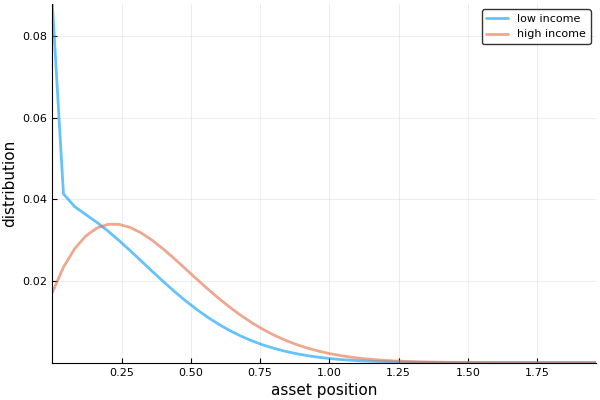

In [21]:
# Plot stationary distribution at the equilibrium
n = 50 # Determine the max asset level to show in the plot
p = plot(size = (600, 400), grid = true)
plot!(p, am.a_vals[1:n], am.g[:,1:n]', lw=2, alpha=0.6, lab=["low income" "high income"])
plot!(p, leg=:topright)
plot!(p, xlabel = "asset position", ylabel = "distribution")

In [22]:
am.r

0.04605980008753249